## Testing the Unet CNN Pixel classification model for grouping

This version of the UNET model uses the 

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import timeit
import statistics
import time
import torch
import torch_geometric
import importlib
from collections import defaultdict
import copy

from data_utils import synthetic_data
from data_utils import graph_constructors
from data_utils import group_to_image_constructors

import networkx as nx

import importlib

from Unet import helper
from Unet import simulation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms, datasets, models
import torchvision.utils

from Unet import loss as Unet_loss

from torchsummary import summary

In [2]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)
importlib.reload(group_to_image_constructors)

<module 'data_utils.group_to_image_constructors' from '/home/a/Documents/GNN-for-trans-grouping/GNN-for-trans-grouping/data_utils/group_to_image_constructors.py'>

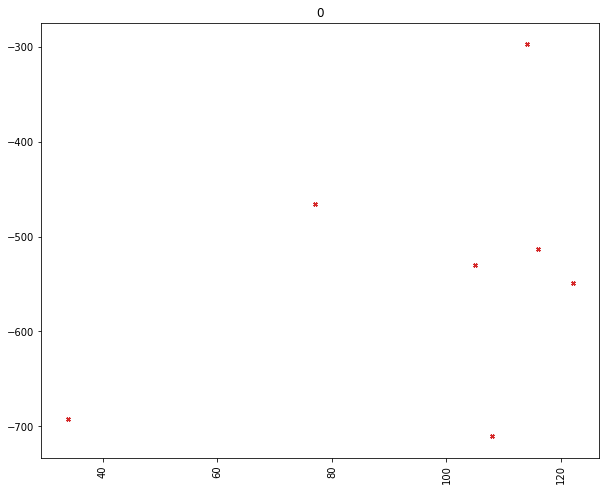

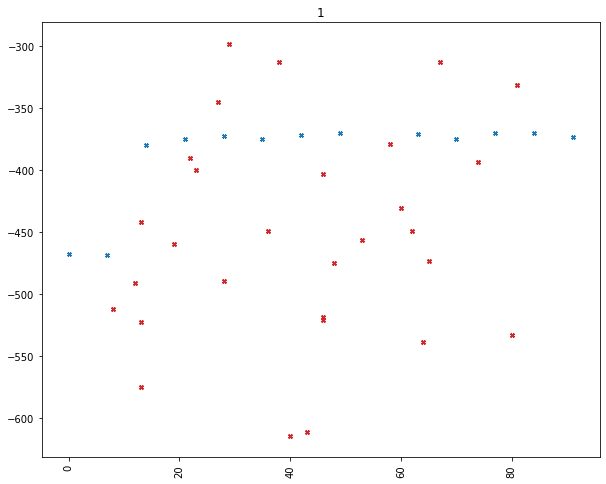

In [3]:
colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(2):
    d_lst, a_lst, g_lst, t_lst = synthetic_data.make_a_group()
    
    d_arr = np.array(d_lst)
    a_arr = np.array(a_lst)
    g_arr = np.array(g_lst)    
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
    for g in g_lst:
        mask = (g_arr == g)
        
        ax1.scatter(d_arr[mask], a_arr[mask], s=10, c=colour_list[g%10], marker='x')
        ax1.set_title(str(i))
        #ax1.legend(loc="upper right")
    
    for ax1 in fig.axes:
        matplotlib.pyplot.sca(ax1)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
    plt.show

In [4]:
d_lst, a_lst, g_lst, t_lst = synthetic_data.make_a_group()

In [5]:
for _ in range(100):
    d_lst, a_lst, g_lst, t_lst = synthetic_data.make_a_group()
    print(max(d_lst))

182
196
168
177
128
127
52
117
167
56
81
22
196
195
97
188
108
209
126
119
112
56
161
182
147
147
189
119
189
105
147
98
189
28
80
119
84
172
168
45
182
105
116
49
78
199
189
42
79
143
78
196
126
199
91
76
81
49
72
161
85
108
159
102
94
160
70
112
98
182
107
119
182
77
72
77
107
135
178
182
166
147
41
35
182
133
140
165
173
43
154
73
34
133
93
67
133
133
176
95


In [6]:
g_lst

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [7]:
d_arr = np.array(d_lst)
a_arr = np.array(a_lst)
g_arr = np.array(g_lst)

In [8]:
norm_a_arr = graph_constructors.normalise_amounts(a_arr)

### Unet demo

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


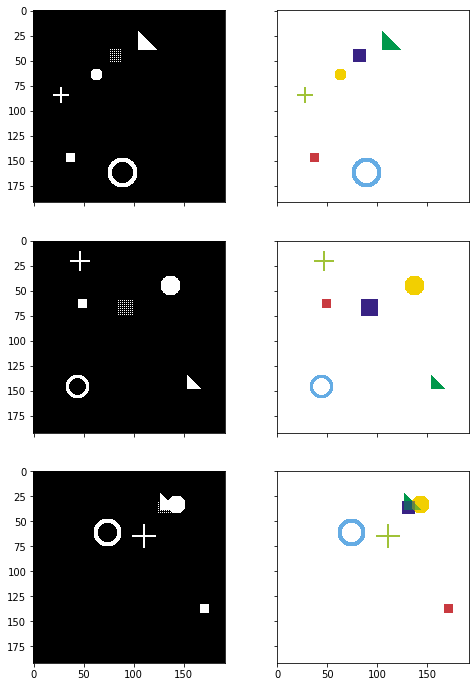

In [9]:
# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image (black and white), Right: Target mask (6ch)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [ ]:
class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 4

dataloaders_orig = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [ ]:
dataloaders_orig['train'].__dict__

In [ ]:
dataloaders_orig['train'].dataset.__dict__

In [ ]:
dataloaders_orig['train'].dataset.input_images.dtype

In [ ]:
dataloaders_orig['val'].dataset.input_images.dtype

In [ ]:
dataloaders_orig['val'].dataset.input_images.shape

In [ ]:
dataloaders_orig['val'].dataset.target_masks.dtype

#### my dataloaders

In [ ]:
out_img, out_target_perm = group_to_image_constructors.make_an_image_from_group(*np.array(synthetic_data.make_a_group()),permute_group_ids = False)


In [19]:
class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.sim_data = [group_to_image_constructors.make_an_image_from_group(*np.array(synthetic_data.make_a_group()),permute_group_ids = False) for _ in range(count)]
        self.input_images = np.array([x[0] for  x in self.sim_data]).astype('uint8')
        self.target_masks = np.array([x[1] for  x in self.sim_data]).astype('float32')
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 4

#it is at this next step that the numpy arrays are converted to tensors
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [20]:
dataloaders['val'].dataset.target_masks.shape

(200, 4, 224, 224)

In [21]:
dataloaders['val'].dataset.input_images.shape

(200, 224, 224, 3)

torch.Size([4, 3, 224, 224]) torch.Size([4, 4, 224, 224])


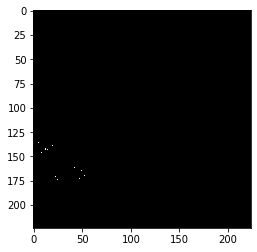

In [22]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[3]))

In [8]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNetUNet(n_class=2)
# model = model.to(device)

# check keras-like model summary using torchsummary
# from torchsummary import summary
# summary(model, input_size=(3, 224, 224))
# summary(model, input_size=(3, 512, 512))

In [ ]:
# def calc_loss(pred, target, metrics, bce_weight=0.5):
    
#     #add a new dimension after batch and broadcast/copy the predictions over this dimension
#     broadcast_preds = batch_pred.unsqueeze(1).repeat(1,24,1,1,1)
    
#     #create the list of permutations of 4 group labels
#     perms = torch.tensor([x for x in itertools.permutations([0,1,2,3])]).type(torch.long)
    
#     #create the permuted targets
#     perms_target = target[:,perms,:,:]
    
#     #get the BCE loss
#     batch_mins, _ = torch.min(torch.mean(F.binary_cross_entropy_with_logits(broadcast_preds, perms_target, reduction = 'none'), dim = (2,3,4)), dim = 1)
#     bce = torch.mean(batch_mins)
    
#     #get the dice loss
#     broadcast_preds = F.sigmoid(broadcast_preds)    
#     smooth = 1
    
#     intersection = (broadcast_preds*perms_target).sum(dim=3).sum(dim=3)
#     loss = (1 - ((2. * intersection + smooth) / (broadcast_preds.sum(dim=3).sum(dim=3) + perms_target.sum(dim=3).sum(dim=3) + smooth)))
#     batch_dice_mins, _ = torch.min(torch.mean(loss, dim = 2), dim = 1)
#     dice = torch.mean(batch_dice_mins)
    
#     #combine losses
#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss

In [9]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = Unet_loss.dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
importlib.reload(Unet_loss)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 4
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=300, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=600)

cuda:0
Epoch 0/599
----------
LR 0.0001


/home/a/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/a/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.012486, dice: 0.400259, loss: 0.206373
val: bce: 0.001687, dice: 0.368063, loss: 0.184875
saving best model
1m 16s
Epoch 1/599
----------
LR 0.0001
train: bce: 0.002756, dice: 0.299435, loss: 0.151096
val: bce: 0.001602, dice: 0.251017, loss: 0.126310
saving best model
1m 16s
Epoch 2/599
----------
LR 0.0001
train: bce: 0.003362, dice: 0.259507, loss: 0.131435
val: bce: 0.001527, dice: 0.247124, loss: 0.124325
saving best model
1m 16s
Epoch 3/599
----------
LR 0.0001
train: bce: 0.001370, dice: 0.190308, loss: 0.095839
val: bce: 0.000664, dice: 0.108943, loss: 0.054803
saving best model
1m 17s
Epoch 4/599
----------
LR 0.0001
train: bce: 0.000760, dice: 0.122056, loss: 0.061408
val: bce: 0.000838, dice: 0.106621, loss: 0.053729
saving best model
1m 17s
Epoch 5/599
----------
LR 0.0001
train: bce: 0.000932, dice: 0.114795, loss: 0.057864
val: bce: 0.000723, dice: 0.102130, loss: 0.051426
saving best model
1m 17s
Epoch 6/599
----------
LR 0.0001
train: bce: 0.000465, dice: 

KeyboardInterrupt: 

In [19]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

https://discuss.pytorch.org/t/save-and-load-model/6206/3

In [116]:
torch.save(model, '/home/a/Documents/GNN-for-trans-grouping/GNN-for-trans-grouping/Unet_model_multi_seq_strict_encoding.pt')

/home/a/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNetUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/a/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/a/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/a/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be check

In [10]:
model = torch.load('/home/a/Documents/GNN-for-trans-grouping/GNN-for-trans-grouping/Unet_model_multi_seq_strict_encoding.pt')
# model = torch.load(r'C:\Users\andy.knapper\Documents\OW\Categorisation\ML grouping\GNN-for-trans-grouping\Unet_model_1.pt')

In [ ]:
# sim_data = [group_to_image_constructors.make_an_image(*np.array(synthetic_data.make_a_group())) for _ in range(3)]
# input_images = np.array([x[0] for  x in sim_data]).astype('uint8')
# target_masks = np.array([x[1] for  x in sim_data]).astype('float32')

In [ ]:
# model.eval()
# output = model(torch.tensor(test_img))
# prediction = torch.argmax(output)

In [8]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

In [59]:
train_set = SimDataset(1000, transform = trans)
val_set = SimDataset(2, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [72]:
from sklearn import metrics

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
for i, (inputs, labels) in enumerate(dataloaders['train']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    a_arr, d_arr = np.nonzero(np.max(reverse_transform(inputs[0].cpu()), axis = 2))
    
    p = torch.nn.functional.softmax(outputs[0], dim=1)
    p_arr = p.cpu().data.numpy()
    
    pred_labels = np.argmax(p_arr, axis = 0)[a_arr, d_arr]
    target_labels = np.argmax(labels[0].cpu().data.numpy(), axis = 0)[a_arr, d_arr]
    
    ari = metrics.adjusted_rand_score(pred_labels, target_labels)
      
    plot_preds_and_targets(d_arr, a_arr, pred_labels, target_labels, ari, i)

    
    print(i, ari)

0 0.3544184673297289
1 1.0
2 0.0
3 0.0
4 0.1466375624196394
5 0.01602959309494447
6 0.0
7 0.18731450172024272
8 0.39613561576102707
9 0.0
10 0.0
11 1.0
12 1.0
13 0.0
14 0.0
15 1.0
16 0.0
17 0.0
18 0.17212619262594495
19 1.0
20 0.0
21 1.0
22 1.0
23 1.0
24 0.0
25 0.3543277179498637
26 0.0
27 0.8816820680781378
28 1.0
29 0.0
30 0.0
31 0.09706281825692052
32 0.89473449912788
33 0.5831167363543903
34 0.0
35 0.0
36 0.0
37 0.8708692029991669
38 0.21340273259596615
39 0.19719866420008167
40 0.48932190179267343
41 0.7400158191787434
42 0.6571258199165176
43 0.0
44 0.7027590784109226
45 0.18338108882521495
46 0.0
47 0.0
48 0.16304347826086954
49 0.0
50 1.0
51 0.24661781285231107
52 1.0
53 1.0
54 0.0
55 0.22190201729106626
56 0.8175892395240558
57 0.0
58 1.0
59 1.0
60 0.0
61 1.0
62 0.580110497237569
63 0.56
64 -0.01061445925227028
65 0.0
66 0.45996978851963743
67 0.5815384615384616
68 0.4324324324324324
69 0.0
70 0.0
71 0.07981729070944786
72 0.0
73 1.0
74 0.0
75 0.8250565753080211
76 1.0
77 0.0


In [71]:
def plot_preds_and_targets(inp_d_arr, inp_a_arr, inp_pred_arr, inp_targets_arr, inp_ari, i):
    colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,16), sharex=True)
    
    for p in inp_pred_arr:
        mask = (inp_pred_arr == p)
        ax1.scatter(inp_d_arr[mask], inp_a_arr[mask], s=10, c=colour_list[p%10], marker='x')

    for t in inp_targets_arr:
        mask = (inp_targets_arr == t)
        ax2.scatter(inp_d_arr[mask], inp_a_arr[mask], s=10, c=colour_list[t%10], marker='x')
        
    for ax in fig.axes:
        matplotlib.pyplot.sca(ax)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    plt.savefig('/home/a/Documents/GNN-for-trans-grouping/GNN-for-trans-grouping/Charts/'+str(ari)+'_'+str(i)+'.png')
        
    plt.close(fig)

In [44]:
dataloaders['train'].dataset.target_masks.shape

(1000, 4, 224, 224)

In [55]:
target = dataloaders['train'].dataset.target_masks[999,:,:,:]

<function matplotlib.pyplot.show(*args, **kw)>

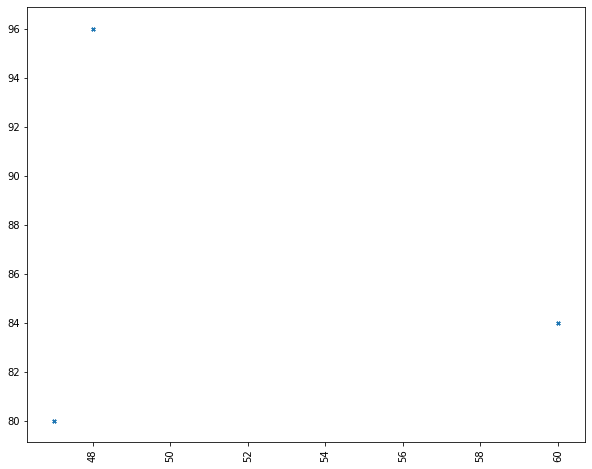

In [56]:
idx = 3
a_arr, d_arr = np.nonzero(np.max(reverse_transform(inputs[idx].cpu()), axis = 2))
# t_arr = (p_arr[idx, :, a_arr, d_arr][:,0]<0.5).astype(int)

t_arr = np.argmax(target, axis = 0)[a_arr, d_arr]

colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
for t in t_arr:
    mask = (t_arr == t)
    ax1.scatter(d_arr[mask], a_arr[mask], s=10, c=colour_list[t%10], marker='x')
    
for ax1 in fig.axes:
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
plt.show

In [58]:
t_arr

array([0, 0, 0])

In [49]:
outputs[3].shape

torch.Size([4, 224, 224])

In [50]:
p = torch.nn.functional.softmax(outputs, dim=1)
p_arr = p.cpu().data.numpy()

<function matplotlib.pyplot.show(*args, **kw)>

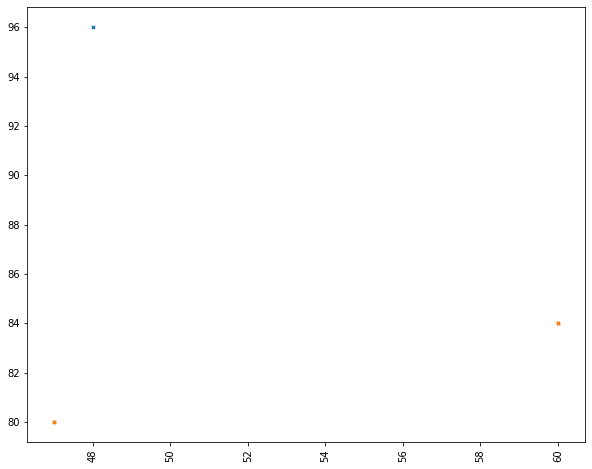

In [51]:
idx = 3
a_arr, d_arr = np.nonzero(np.max(reverse_transform(inputs[idx].cpu()), axis = 2))
# t_arr = (p_arr[idx, :, a_arr, d_arr][:,0]<0.5).astype(int)

t_arr = np.argmax(p_arr[0,:,:,:], axis = 0)[a_arr, d_arr]

colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
for t in t_arr:
    mask = (t_arr == t)
    ax1.scatter(d_arr[mask], a_arr[mask], s=10, c=colour_list[t%10], marker='x')
    
for ax1 in fig.axes:
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
plt.show

In [91]:
p_arr[0,:,:,:].shape

(4, 224, 224)

In [103]:
np.max(p_arr[0,2,a_arr, d_arr])

2.1298797e-37

In [104]:
t_arr

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [110]:
np.argmax(p_arr[0,:,:,:], axis = 0)[a_arr, d_arr]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])